In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cPickle
import os
import json
import pickle
from sklearn.model_selection import train_test_split
%matplotlib inline
# Force matplotlib to not use any Xwindows backend.

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
# Read the data that Ajay labeled. Convert 1,000 to 1000
from IPython.core.debugger import Tracer
df = pd.read_csv('data.csv', thousands=',') ##, na_values=["#DIV/0!", ' ', ''])

In [3]:
# For some reason, there are extra rows. Just use first 300
df = df[:300]

In [4]:
# Some clean up. Replace #DIV/0! with 0
# I think 0 is a reasonable, non-biasing number because if, e.g. #Months is 0, a spend per month of 0 is reasonable
df.replace(to_replace='#DIV/0!',value='0',inplace=True)
df.fillna(0, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 27 columns):
Decision                     300 non-null object
Approved Amount              300 non-null int64
hashed mobile number         300 non-null object
Txn Type                     300 non-null object
Payment Mode                 300 non-null object
Bins                         300 non-null object
Card Types                   300 non-null object
Org                          300 non-null object
Unique Org Count             300 non-null int64
Num_txns                     300 non-null int64
total_amount                 300 non-null float64
Average expense per month    300 non-null float64
largest_txns                 300 non-null float64
first_txns                   300 non-null int64
last_txns                    300 non-null int64
no_months                    300 non-null int64
num_card_txns                300 non-null int64
Percentage_card_txns         300 non-null float64
num_cash_cheque_

In [6]:
def p2f(x):
    return float(x.strip('%'))/100
#df['Percentage_card_txns']=df['Percentage_card_txns'].apply(p2f)

In [7]:
X = df[['Num_txns', 'total_amount','largest_txns', 'no_months', 'num_card_txns', 'num_cash_cheque_txns','num_wallet_txns', 'num_deliveries', 'max_lpg_delivery_amount', 'total_delivery_amount', 'Percentage_card_txns']]
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
y = le.fit_transform(df['Decision'])

In [8]:
X.fillna(0, inplace=True)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [9]:
#X['total_amount'] = pd.to_numeric(X['total_amount'],errors='coerce')
#X['Percentage_card_txns'] = pd.to_numeric(X['Percentage_card_txns'],errors='coerce')

In [10]:
#*** Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (len(X_train))
print (len(X_test))

240
60


In [11]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 183, 1: 57}

In [12]:
from sklearn import ensemble
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
model = XGBClassifier() #tree.DecisionTreeClassifier() #XGBClassifier() #tree.DecisionTreeClassifier() #GaussianNB() #XGBClassifier() #tree.DecisionTreeClassifier() #** XGBClassifier() #** ensemble.RandomForestClassifier() #** tree.DecisionTreeClassifier()  #** XGBClassifier() #** ensemble.RandomForestClassifier()
model.fit(X_train, y_train)

#scores = cross_val_score(model, X, y, cv=5)
#print (scores.mean())

#*** Test
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

#*** Get Accuracy
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y_train, y_train_pred)
#print ('Train accuracy: ', train_acc)
print ('Test accuracy: ', test_acc)

('Test accuracy: ', 0.93333333333333335)


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
# save the classifier
stats = {"train accuracy": train_acc,"test accuracy":test_acc, 'label':'initial model',}

model_filename = os.path.join(os.environ['OUTPUT_DIR'],'model.dat')
pickle.dump(model, open(model_filename, 'wb'))
stats_filename = os.path.join(os.environ['OUTPUT_DIR'],'stats.json')
with open(stats_filename, 'wb') as f:
    f.write(json.dumps(stats))

In [14]:
#scores

In [15]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 183, 1: 57}

In [16]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 50, 1: 10}

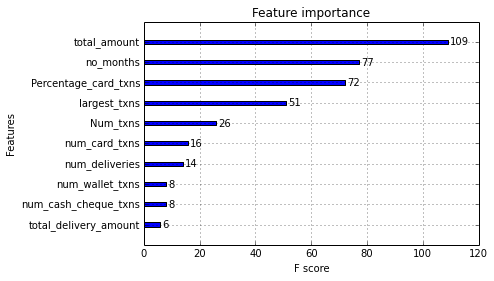

In [17]:
import xgboost as xgb
xgb.plot_importance(model)

In [18]:
# Ignore everything below for now.
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import mean_squared_error
from IPython.core.debugger import Tracer
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                             scoring = 'accuracy', cv = 5, n_jobs = -1)

/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
optimized_GBM.fit(X_train, y_train)

In [ ]:
optimized_GBM.grid_scores_

In [ ]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 5}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_GBM.fit(X_train, y_train)

In [ ]:
optimized_GBM.grid_scores_

In [20]:
xgdmat = xgb.DMatrix(X_train, y_train) # Create our DMatrix to make XGBoost more efficient

In [21]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':5, 'min_child_weight':5} 
#'multi:softmax', 'num_class':3
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error
#metrics = ['merror']

In [22]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
43,0.070833,0.038640,0.043750,0.009660
44,0.070833,0.038640,0.044792,0.009660
45,0.066667,0.042492,0.044792,0.007795
46,0.066667,0.042492,0.044792,0.005311
47,0.062500,0.043700,0.044791,0.007065


In [23]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':5, 'min_child_weight':5} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)

In [24]:
%matplotlib inline
#import seaborn as sns
#sns.set(font_scale = 1.5)

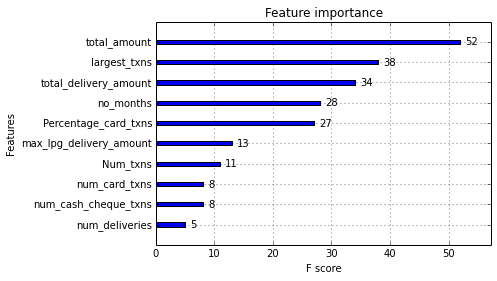

In [25]:
xgb.plot_importance(final_gb)

In [26]:
testdmat = xgb.DMatrix(X_test)

In [27]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([ 0.01183783,  0.00969792,  0.03513375,  0.01671076,  0.22050838,
        0.01020202,  0.00661394,  0.01020202,  0.01020202,  0.01183783,
        0.01537957,  0.01537957,  0.01209442,  0.02996225,  0.00784605,
        0.07191801,  0.01911235,  0.01831638,  0.01020202,  0.00661394,
        0.96956259,  0.00642063,  0.96893233,  0.63763291,  0.97177571,
        0.14665608,  0.01537957,  0.61291003,  0.00877697,  0.00777758,
        0.02639156,  0.00818321,  0.00877697,  0.01499328,  0.00661394,
        0.84684289,  0.00642063,  0.95951986,  0.03119238,  0.01242978,
        0.51560026,  0.00642063,  0.01384237,  0.00969792,  0.17404521,
        0.93916827,  0.00661394,  0.00852099,  0.01911235,  0.01831638,
        0.01183783,  0.68583858,  0.00661394,  0.01537957,  0.96795648,
        0.03119238,  0.03110979,  0.01020202,  0.00661394,  0.00661394], dtype=float32)

In [28]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [29]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.94999999999999996, 0.050000000000000044)

In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

In [30]:
test_acc = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y_train, y_train_pred)

In [31]:
# save the classifier
stats = {"train accuracy": train_acc,"test accuracy":test_acc, 'label':'final model with specific params',}

model_filename = os.path.join(os.environ['OUTPUT_DIR'],'model.dat')
pickle.dump(final_gb, open(model_filename, 'wb'))
stats_filename = os.path.join(os.environ['OUTPUT_DIR'],'stats.json')
with open(stats_filename, 'wb') as f:
    f.write(json.dumps(stats))